# **Download the files**

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
import requests
url = "https://drive.google.com/file/d/1kzwz_3ogZb67YbDMSQsslChxX-6xAUW2"
r = requests.get(url)
with open('models.zip', 'wb') as f:
    f.write(r.content) 

In [18]:
!unzip /content/gdrive/MyDrive/models.zip

Archive:  /content/gdrive/MyDrive/models.zip
  inflating: images/day.jpg          
  inflating: images/night.jpg        
  inflating: models/model.pt         
  inflating: videos/traffic_day.mp4  
  inflating: videos/traffic_night.mp4  


# **Setup**

In [19]:
!mkdir outputs

In [20]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 21, 18

# **COCO Names Python File**

In [21]:
%%writefile coco_names.py
COCO_INSTANCE_CATEGORY_NAMES = ['obj','bike','bus','car','motor','person','rider','traffic light','traffic sign','train','truck']


Writing coco_names.py


# **Detection Utility Script**

In [22]:
%%writefile detect_utils.py
import torchvision.transforms as transforms
import cv2
import numpy as np

from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image

    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]

    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()

    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

    return boxes, pred_classes, outputs[0]['labels']

def draw_boxes(boxes, classes, labels, image):
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image


Writing detect_utils.py


# **Object Detection in Images**

In [3]:
%%writefile detect_img.py
import torchvision
import torch
import argparse
import cv2
import detect_utils
import time

start = time.time()

from PIL import Image

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image/video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
model = torch.load('/content/models/model.pt')
# load the model on to the computation device
model.eval().to(device)

# read the image and run the inference for detections
image = Image.open(args['input'])
boxes, classes, labels = detect_utils.predict(image, model, device, 0.7)
image = detect_utils.draw_boxes(boxes, classes, labels, image)
# cv2.imshow('Image', image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
cv2.imwrite(f"outputs/{save_name}.jpg", image)
# cv2.waitKey(0)

end = time.time()

print(f"Execution time: {end - start} seconds")

Overwriting detect_img.py


In [5]:
!python detect_img.py --input /content/images/day.jpg

Execution time: 3.9490280151367188 seconds


In [6]:
!python detect_img.py --input /content/outputs/night.jpg

Execution time: 3.242299795150757 seconds


# **Output**

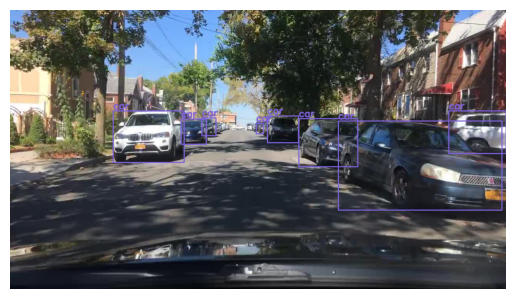

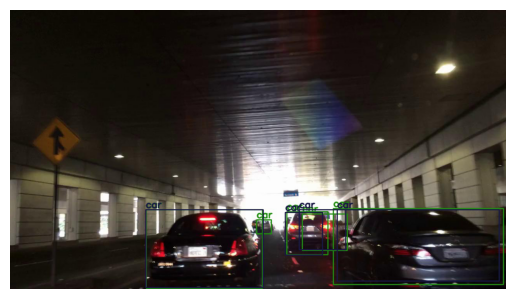

In [10]:
import matplotlib.pyplot as plt
import matplotlib


image_1 = plt.imread('/content/outputs/day.jpg')
image_2 = plt.imread('/content/outputs/night.jpg')

plt.imshow(image_1)
plt.axis('off')
plt.show()

plt.imshow(image_2)
plt.axis('off')
plt.show()

# **Object Detection in Videos**



In [11]:
%%writefile detect_vid.py
import torchvision
import cv2
import torch
import argparse
import time
import detect_utils
import time

start = time.time()

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model 
model = torch.load('/content/models/model.pt')
# load the model onto the computation device
model = model.eval().to(device)

cap = cv2.VideoCapture(args['input'])

if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"outputs/{save_name}.mp4", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, 
                      (frame_width, frame_height))

frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        # get the start time
        start_time = time.time()
        with torch.no_grad():
            # get predictions for the current frame
            boxes, classes, labels = detect_utils.predict(frame, model, device, 0.7)
        
        # draw boxes and show current frame on screen
        image = detect_utils.draw_boxes(boxes, classes, labels, frame)

        # get the end time
        end_time = time.time()
        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        print(f"Frame counter: {frame_count}, FPS: {fps}")
        # write the FPS on the current frame
        cv2.putText(image, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2)
        # press `q` to exit
        wait_time = max(1, int(fps/4))
        # convert from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # cv2.imshow('image', image)
        out.write(image)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

    else:
        break

# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()

end = time.time()

# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

print(f"Execution time: {end - start} seconds")


Writing detect_vid.py


In [12]:
!python detect_vid.py --input /content/videos/traffic_day.mp4

Frame counter: 1, FPS: 0.5113843037856155
Frame counter: 2, FPS: 15.466977409671877
Frame counter: 3, FPS: 18.15323090240208
Frame counter: 4, FPS: 18.89258044755144
Frame counter: 5, FPS: 17.375416851358573
Frame counter: 6, FPS: 21.035467822179424
Frame counter: 7, FPS: 22.810006525995213
Frame counter: 8, FPS: 21.736762731979333
Frame counter: 9, FPS: 22.75222271043196
Frame counter: 10, FPS: 24.30959156586703
Frame counter: 11, FPS: 25.152794852266528
Frame counter: 12, FPS: 24.62703375549723
Frame counter: 13, FPS: 24.3310264814224
Frame counter: 14, FPS: 25.465862795456065
Frame counter: 15, FPS: 24.536990019773253
Frame counter: 16, FPS: 25.021052192016988
Frame counter: 17, FPS: 25.457670737332784
Frame counter: 18, FPS: 24.83835512601857
Frame counter: 19, FPS: 24.962529162500594
Frame counter: 20, FPS: 24.868692857735773
Frame counter: 21, FPS: 25.632697960655378
Frame counter: 22, FPS: 25.617511971073977
Frame counter: 23, FPS: 25.16335799091689
Frame counter: 24, FPS: 24.74

In [13]:
!python detect_vid.py --input /content/videos/traffic_night.mp4

Frame counter: 1, FPS: 0.6893405014728368
Frame counter: 2, FPS: 22.753333550326033
Frame counter: 3, FPS: 22.687856331476173
Frame counter: 4, FPS: 22.701732545992844
Frame counter: 5, FPS: 23.237012537326663
Frame counter: 6, FPS: 22.36592350064789
Frame counter: 7, FPS: 29.848448619413606
Frame counter: 8, FPS: 32.61892133608119
Frame counter: 9, FPS: 32.1809490927226
Frame counter: 10, FPS: 33.48184336358774
Frame counter: 11, FPS: 34.10696483025005
Frame counter: 12, FPS: 33.087240168816315
Frame counter: 13, FPS: 33.151574071878535
Frame counter: 14, FPS: 35.30172624207789
Frame counter: 15, FPS: 34.33423105573792
Frame counter: 16, FPS: 33.61709426370755
Frame counter: 17, FPS: 35.24032935641069
Frame counter: 18, FPS: 33.30319271416435
Frame counter: 19, FPS: 33.514214942069515
Frame counter: 20, FPS: 31.99292148801306
Frame counter: 21, FPS: 33.45673832409365
Frame counter: 22, FPS: 33.781715381083934
Frame counter: 23, FPS: 32.99483952171177
Frame counter: 24, FPS: 33.6338077